In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
elecom = pd.read_csv('/content/Electric_Production.csv')

In [ ]:
elecom.head(5)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [ ]:
elecom.tail(5)

,DATE,Value
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212
396,01-01-2018,129.4048


In [ ]:
elecom.shape


(397, 2)

In [ ]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [ ]:
from datetime import datetime
elecom['DATE']=pd.to_datetime(elecom['DATE'],infer_datetime_format=True)

In [ ]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [ ]:
elecomind = elecom.set_index('DATE',inplace=False)

In [ ]:
elecomind.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


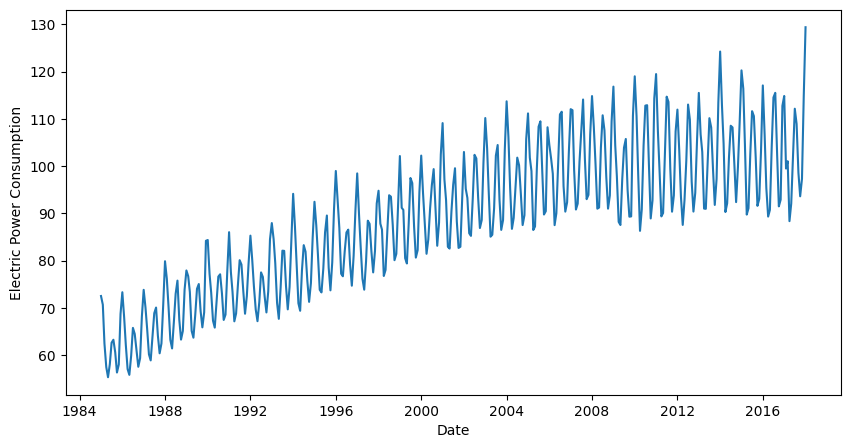

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(elecomind)

In [ ]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
      #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    elecom_test = adfuller(timeseries['Value'], autolag='AIC')
    dfoutput = pd.Series(elecom_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in elecom_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

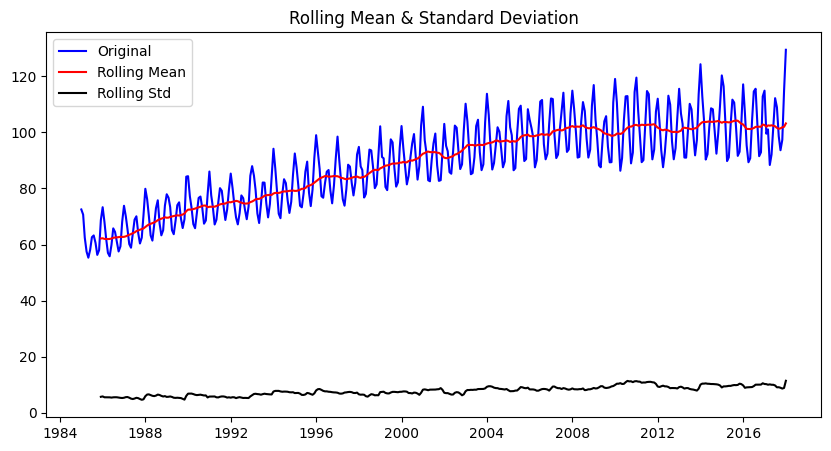

Results of Dickey Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [ ]:
test_stationarity(elecomind)

In [ ]:
elecom_log = np.log(elecomind)

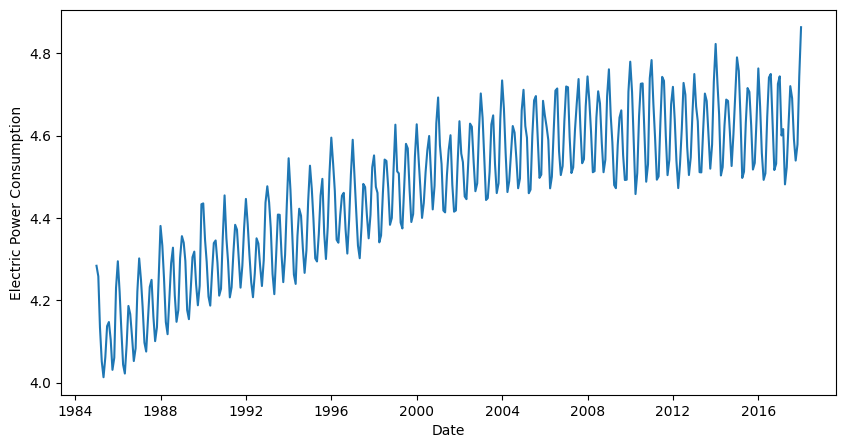

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(elecom_log)

In [ ]:
rollmean_log = elecom_log.rolling(window=12).mean()
rollstd_log = elecom_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

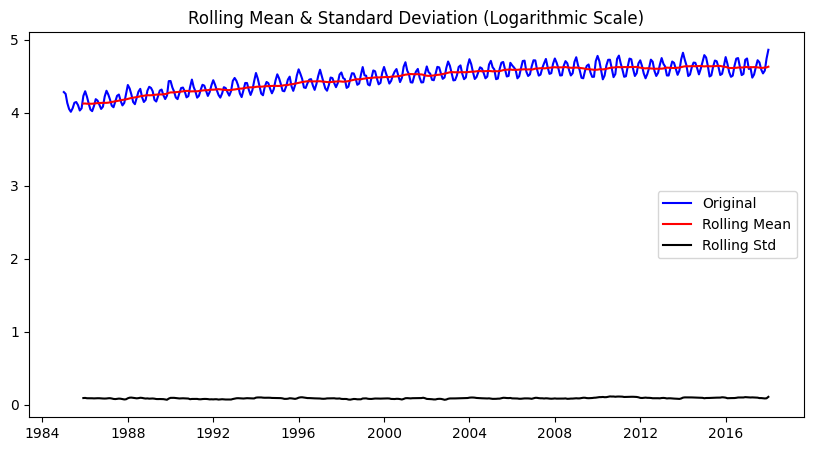

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(elecom_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

In [ ]:
elecom_new = elecom_log - rollmean_log

In [ ]:
elecom_new.head()

,Value
DATE,
1985-01-01,NaN
1985-02-01,NaN
1985-03-01,NaN
1985-04-01,NaN
1985-05-01,NaN


In [ ]:
elecom_new.dropna(inplace=True)

In [ ]:
elecom_new.head()

,Value
DATE,
1985-12-01,0.103961
1986-01-01,0.167724
1986-02-01,0.095629
1986-03-01,0.007329
1986-04-01,-0.079115


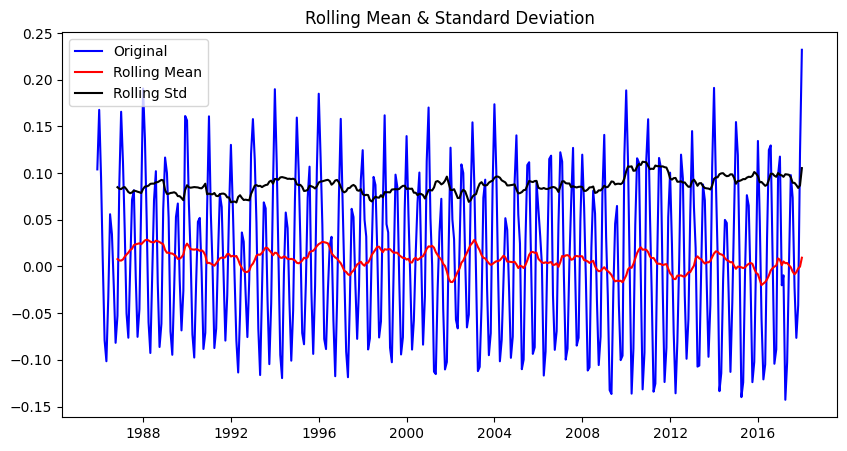

Results of Dickey Fuller Test:
Test Statistic                  -5.211586
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    370.000000
Critical Value (1%)             -3.448148
Critical Value (5%)             -2.869383
Critical Value (10%)            -2.570948
dtype: float64


In [ ]:
test_stationarity(elecom_new)

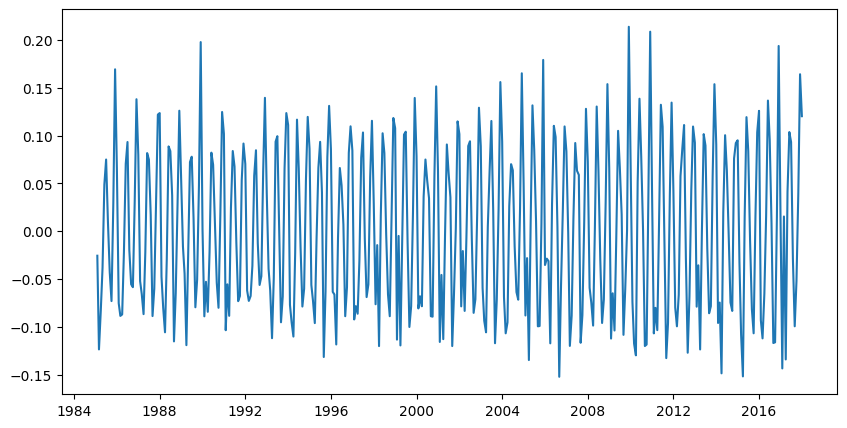

In [ ]:
elecom_log_diff = elecom_log - elecom_log.shift()
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)

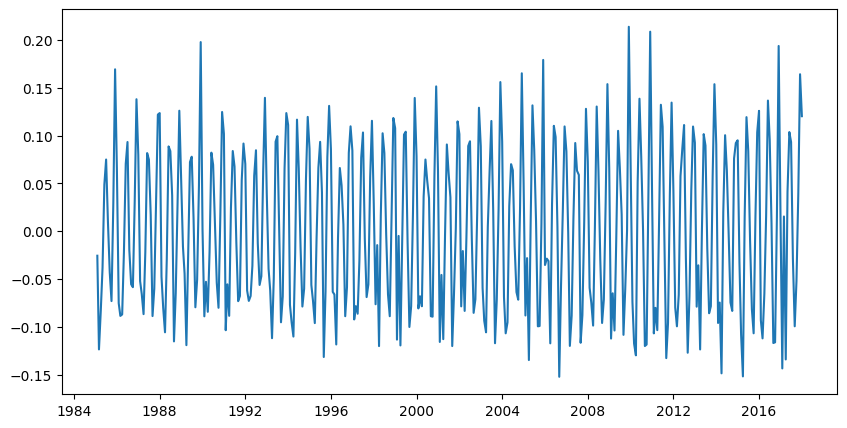

In [ ]:
elecom_log_diff.dropna(inplace=True)
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)

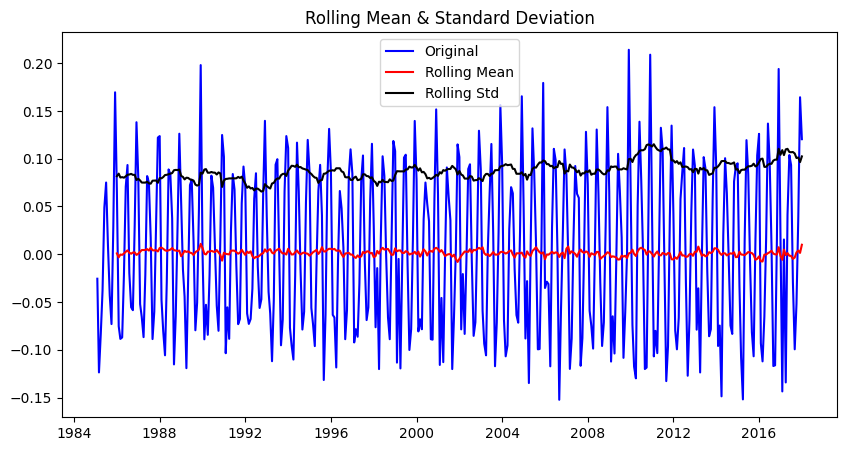

Results of Dickey Fuller Test:
Test Statistic                -6.748333e+00
p-value                        2.995161e-09
#Lags Used                     1.400000e+01
Number of Observations Used    3.810000e+02
Critical Value (1%)           -3.447631e+00
Critical Value (5%)           -2.869156e+00
Critical Value (10%)          -2.570827e+00
dtype: float64


In [ ]:
test_stationarity(elecom_log_diff)

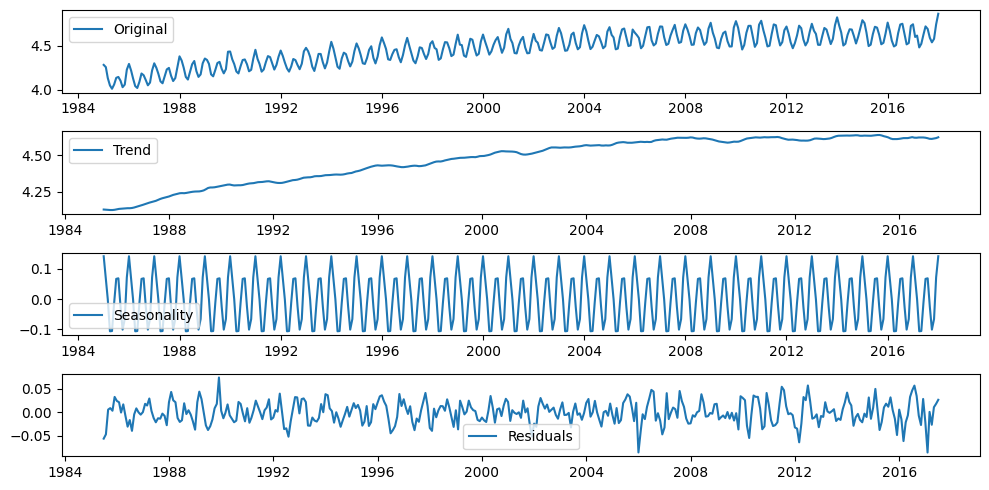

In [ ]:
# Assuming the data has a monthly frequency, you should specify the period as 12
decomposition = seasonal_decompose(elecom_log, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(elecom_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
elecom_decompose = residual
elecom_decompose.dropna(inplace=True)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

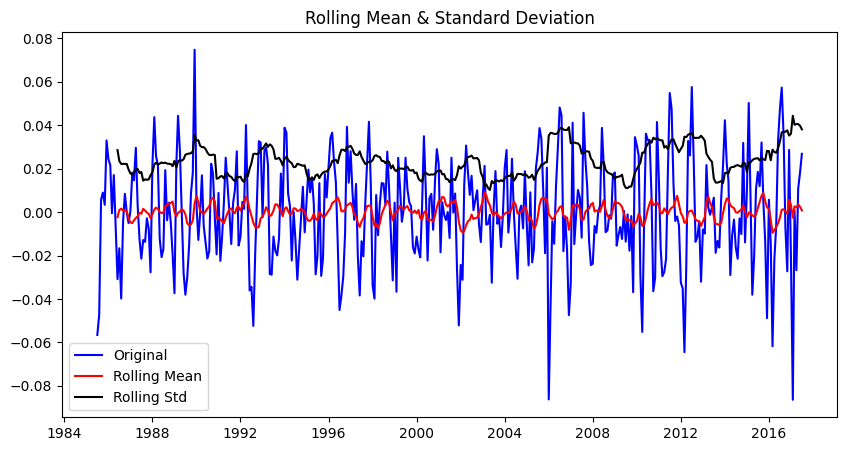

In [ ]:
rollmean_decompose = elecom_decompose.rolling(window=12).mean()
rollstd_decompose = elecom_decompose.rolling(window=12).std()

plt.figure(figsize=(10,5))
plt.plot(elecom_decompose, color='blue', label='Original')
plt.plot(rollmean_decompose, color='red', label='Rolling Mean')
plt.plot(rollstd_decompose, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [ ]:
lag_acf = acf(elecom_log_diff, nlags=20)
lag_pacf = pacf(elecom_log_diff, nlags=20, method='ols')

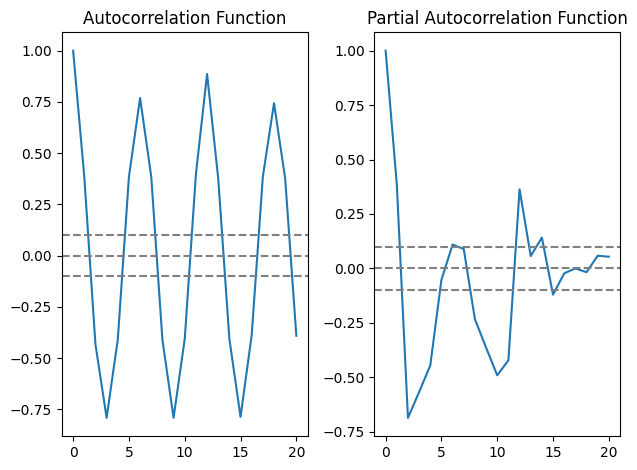

In [ ]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(elecom_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

Plotting AR model


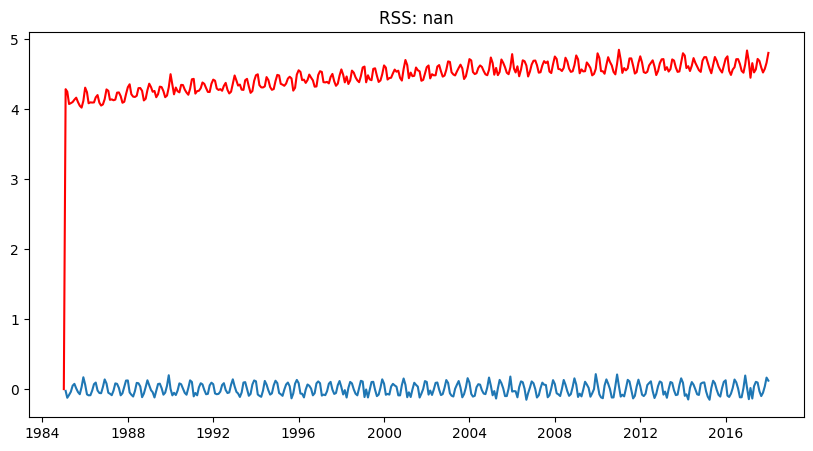

In [ ]:
model1 = ARIMA(elecom_log, order=(3,1,0))
results_AR = model1.fit(method_kwargs={"disp": -1})
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - elecom_log_diff['Value'])**2))
print('Plotting AR model')

In [ ]:


# Use:
from statsmodels.tsa.arima.model import ARIMA

# Then, when creating your ARIMA model:
model = ARIMA(elecom_log, order=(3, 1, 3))  # Assuming elecom_log is your time series data
results_ARIMA = model.fit()

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

,0
DATE,
1985-01-01,0.000000
1985-02-01,4.283658
1985-03-01,4.247654
1985-04-01,4.066964
1985-05-01,4.079499


In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

,0
DATE,
1985-01-01,0.000000
1985-02-01,4.283658
1985-03-01,8.531312
1985-04-01,12.598276
1985-05-01,16.677775


In [ ]:
predictions_ARIMA_log = pd.Series(elecom_log.iloc[0], index=elecom_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

,0
DATE,
1985-01-01,0.000000
1985-02-01,4.283658
1985-03-01,8.531312
1985-04-01,12.598276
1985-05-01,16.677775


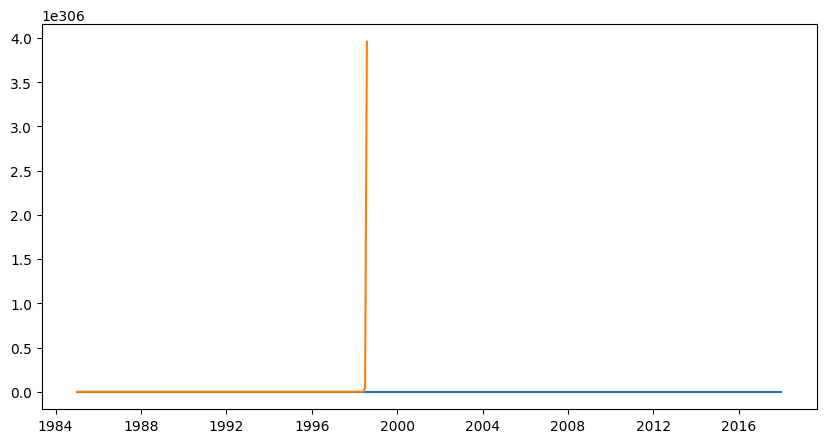

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(10,5))
plt.plot(elecomind)
plt.plot(predictions_ARIMA)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
# Re-executing the code that creates elecom_log
elecom = pd.read_csv('/content/Electric_Production.csv')
from datetime import datetime
elecom['DATE']=pd.to_datetime(elecom['DATE'],infer_datetime_format=True)
elecomind = elecom.set_index('DATE',inplace=False)
elecom_log = np.log(elecomind) # This line is crucial for defining elecom_log

# Now you should be able to call elecom_log.head()
elecom_log.head()

,Value
DATE,
1985-01-01,4.283658
1985-02-01,4.258049
1985-03-01,4.134369
1985-04-01,4.051287
1985-05-01,4.013046
